In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from scipy.sparse import lil_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [6]:
df = pd.read_csv("/content/drive/MyDrive/Copy of complaints.csv")
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


## Data preprocessing

In [7]:
df.rename(columns={'Unnamed: 0': 'Complaint_No'}, inplace=True)

In [8]:
df.head()

,Complaint_No,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [9]:
unique=df["product"].unique()
unique

array(['credit_card', 'retail_banking', 'credit_reporting',
       'mortgages_and_loans', 'debt_collection'], dtype=object)

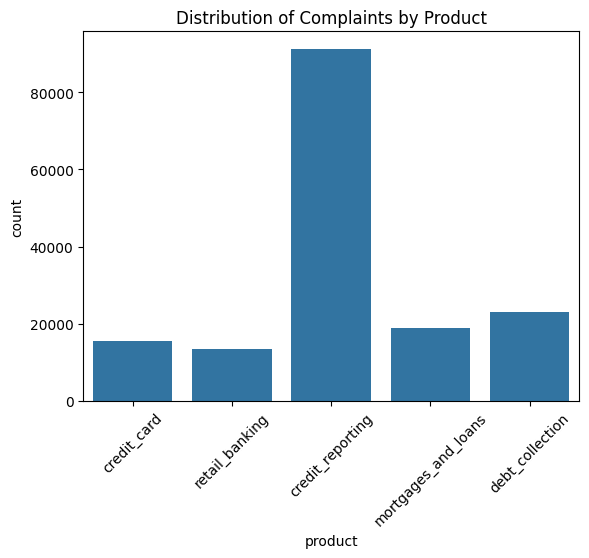

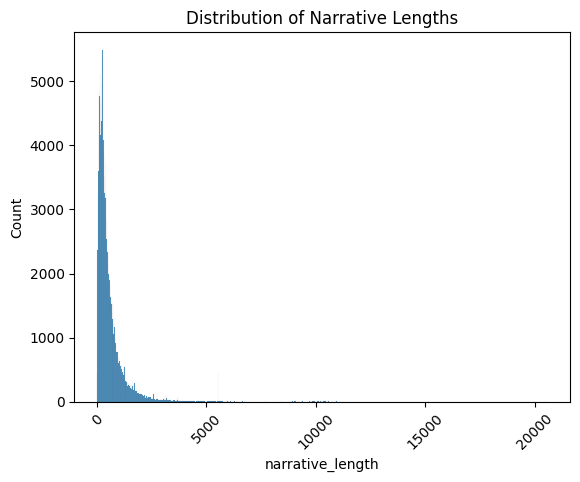

In [10]:
sns.countplot(x='product', data=df)
plt.title('Distribution of Complaints by Product')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

# Histogram of narrative lengths, handling NaN values
df['narrative_length'] = df['narrative'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
sns.histplot(df['narrative_length'])
plt.title('Distribution of Narrative Lengths')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()


## Encoding Product Columns values

In [11]:
df["product"] = df["product"].replace({
    "credit_card": "1",
    "retail_banking": "2",
    "credit_reporting": "3",
    "mortgages_and_loans": "4",
    "debt_collection": "5"
}, regex=False)
df.head()

,Complaint_No,product,narrative,narrative_length
0,0,1,purchase order day shipping amount receive pro...,1705
1,1,1,forwarded message date tue subject please inve...,904
2,2,2,forwarded message cc sent friday pdt subject f...,1230
3,3,3,payment history missing credit report speciali...,903
4,4,3,payment history missing credit report made mis...,851


In [12]:
df = df.drop("narrative_length", axis = 1)
df

,Complaint_No,product,narrative
0,0,1,purchase order day shipping amount receive pro...
1,1,1,forwarded message date tue subject please inve...
2,2,2,forwarded message cc sent friday pdt subject f...
3,3,3,payment history missing credit report speciali...
4,4,3,payment history missing credit report made mis...
...,...,...,...
162416,162416,5,name
162417,162417,1,name
162418,162418,5,name
162419,162419,1,name


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Complaint_No  162421 non-null  int64 
 1   product       162421 non-null  object
 2   narrative     162411 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [14]:
df.isnull().sum()

Complaint_No     0
product          0
narrative       10
dtype: int64

In [15]:
df=df.dropna()

In [16]:
df.duplicated().sum()

0

### Text preperation

## 1- lower case

In [17]:
df["narrative"]=df["narrative"].str.lower()
df.head()

,Complaint_No,product,narrative
0,0,1,purchase order day shipping amount receive pro...
1,1,1,forwarded message date tue subject please inve...
2,2,2,forwarded message cc sent friday pdt subject f...
3,3,3,payment history missing credit report speciali...
4,4,3,payment history missing credit report made mis...


## 2- Remove puncatution

In [18]:
punc=string.punctuation
def remove_punc(text):
    return text.translate(str.maketrans('', '',punc))

df["narrative"]=df["narrative"].apply(remove_punc)
df.head()

,Complaint_No,product,narrative
0,0,1,purchase order day shipping amount receive pro...
1,1,1,forwarded message date tue subject please inve...
2,2,2,forwarded message cc sent friday pdt subject f...
3,3,3,payment history missing credit report speciali...
4,4,3,payment history missing credit report made mis...


## 3- remove stop words

In [19]:
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
stop_words


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [20]:
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)
df["narrative"]=df["narrative"].apply(lambda x: remove_stopwords(x))

df.head()

,Complaint_No,product,narrative
0,0,1,purchase order day shipping amount receive pro...
1,1,1,forwarded message date tue subject please inve...
2,2,2,forwarded message cc sent friday pdt subject f...
3,3,3,payment history missing credit report speciali...
4,4,3,payment history missing credit report made mis...


### split data

In [23]:
X = df['narrative'].values

In [24]:
X

array(['purchase order day shipping amount receive product week sent followup email exact verbiage paid two day shipping received order company responded im sorry inform due unusually high order volume order shipped several week stock since early due high demand although continuing take order guaranteeing receive order place due time mask order exact shipping date right however guarantee ship soon soon delivers product u getting small shipment shipping first come first served basis appreciate patience fulfill order quickly recommend keeping order lose place line cancel distributor stock moment prefer cancel please note ask via email cancel accordance cancellation policy agreed checkout electronic inventory online requested order canceled refund issued canceled order sent verification order canceled refunded item particulate respirator refunded subtotal shipping tax total usd visa ending refund called disputed amount stated nothing needed submitted address issue recharged item removing 

In [28]:
y = df["product"]
y

0         1
1         1
2         2
3         3
4         3
         ..
162416    5
162417    1
162418    5
162419    1
162420    3
Name: product, Length: 162411, dtype: object

In [29]:
y.shape

(162411,)

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2 , random_state=42)

In [31]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((129928,), (129928,), (32483,), (32483,))

## BOW from scratch

In [32]:
class BoWVectorizer:
    def __init__(self):
        self.vocabulary = {}  # Dictionary to store the vocabulary
        self.num_sentences = 0  # Number of documents processed

    def set_params(self, **kwargs):  ## use it when find the best params of BOW at gridsearch cv process
        for parameter, value in kwargs.items():
            setattr(self, parameter, value)
        return self

    def fit(self, sentences,y=None):
        # Build the vocabulary
        for sent in sentences:
            for word in sent.split():
                if word not in self.vocabulary:
                    self.vocabulary[word] = len(self.vocabulary)
        self.num_sentences = len(sentences)
        return self

    def transform(self, sentences):
        bow_matrix = lil_matrix((len(sentences), len(self.vocabulary)), dtype=np.int32)
        for i, sent in enumerate(sentences):
            for word in sent.split():
                if word in self.vocabulary:
                    word_index = self.vocabulary[word]
                    bow_matrix[i, word_index] += 1

        return bow_matrix


## Multinomial Naive Bayes Model

In [38]:
bow_vectorizer = BoWVectorizer()

# Define hyperparameters for Multinomial Naive Bayes
naive_bayes = MultinomialNB(alpha=1.5)

pipeline_NB = Pipeline([
    ('bow', bow_vectorizer),
    ('classifier', naive_bayes)
])

pipeline_NB.fit(X_train, y_train)

predictions = pipeline_NB.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.821722131576517


## KNN Model

In [33]:
bow_vectorizer = BoWVectorizer()

# Define hyperparameters for KNN
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

pipeline_knn = Pipeline([
    ('bow', bow_vectorizer),
    ('classifier', knn)
])

pipeline_knn.fit(X_train, y_train)

predictions = pipeline_knn.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.7821629775574916


## LogisticRegression Model

In [34]:
bow_vectorizer = BoWVectorizer()

# Define hyperparameters for Logistic Regression
LR = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs')
pipeline_LR = Pipeline([
    ('bow', bow_vectorizer),
    ('classifier', LR)
])

pipeline_LR.fit(X_train, y_train)

predictions = pipeline_LR.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8574023335283071


## DecisionTreeClassifier Model

In [35]:
bow_vectorizer = BoWVectorizer()

# Define hyperparameters for Decision Tree
dt = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='gini')

pipeline_dt = Pipeline([
    ('bow', bow_vectorizer),
    ('classifier', dt)
])

pipeline_dt.fit(X_train, y_train)

predictions = pipeline_dt.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8254163716405505


## RandomForestClassifier Model

In [36]:
bow_vectorizer = BoWVectorizer()

# Define hyperparameters for Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='gini')

pipeline_rf = Pipeline([
    ('bow', bow_vectorizer),
    ('classifier', rf)
])

pipeline_rf.fit(X_train, y_train)

predictions = pipeline_rf.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.8733183511375181


In [59]:
classesDic = {"1": "credit_card",
    "2": "retail_banking",
    "3": "credit_reporting",
    "4": "mortgages_and_loans",
    "5": "debt_collection"}
print (classesDic.values())

dict_values(['credit_card', 'retail_banking', 'credit_reporting', 'mortgages_and_loans', 'debt_collection'])


## Creating Predict function that takes a sample and predict it

In [64]:
models = [pipeline_NB, pipeline_knn, pipeline_LR, pipeline_dt,pipeline_rf]
ModelsNames = ["Naive Bayes Classifier","KNN Classifier","Logistic Regression", "Decision Tree", "Random Forest"]
# Choose a test sample
test_sample = X_test[1]

def predict(test_sample, models):
    test_sample = np.expand_dims(test_sample, axis=0)
    for i, model in enumerate(models):
        print(f"Model {ModelsNames[i]}: Predicted class is {classesDic[model.predict(test_sample)[0]]}")

predict(test_sample, models)


Model Naive Bayes Classifier: Predicted class is credit_reporting
Model KNN Classifier: Predicted class is credit_reporting
Model Logistic Regression: Predicted class is credit_reporting
Model Decision Tree: Predicted class is credit_reporting
Model Random Forest: Predicted class is credit_reporting


## Comparing the models and Plotting the accuracy of the models

Model Naive Bayes Classifier Accuracy: 0.821722131576517
Model KNN Classifier Accuracy: 0.7821629775574916
Model Logistic Regression Accuracy: 0.8574023335283071
Model Decision Tree Accuracy: 0.8254163716405505
Model Random Forest Accuracy: 0.8733183511375181
Best Model : Random Forest


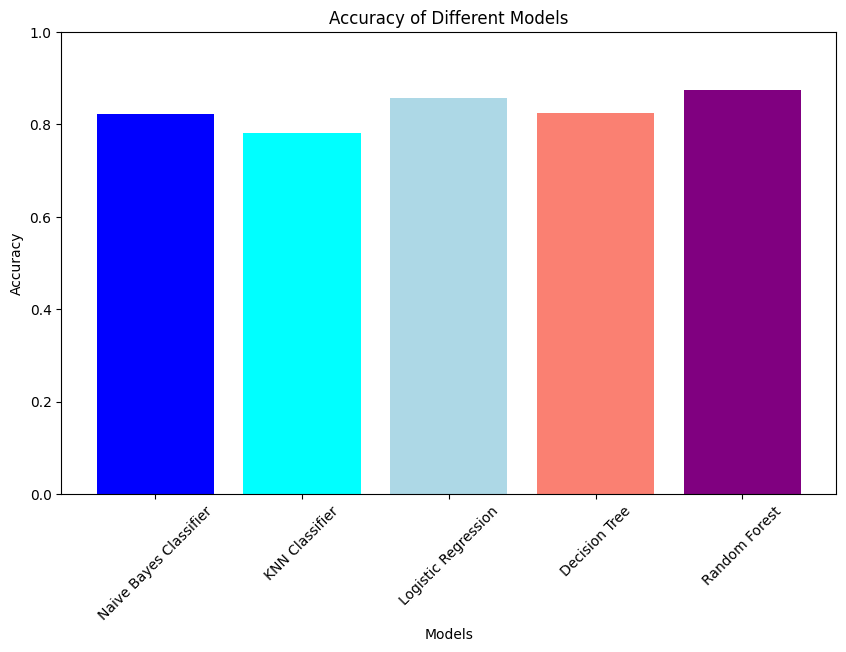

In [70]:
def plot_model_accuracies(models, models_names, accuracies):
    plt.figure(figsize=(10, 6))
    plt.bar(models_names, accuracies, color=['blue', 'cyan', 'lightblue', 'salmon', 'purple'])
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of Different Models')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.show()

accuracies = []

def compare_models(models, test_sample, test_label):
    for i, model in enumerate(models):
        predictions = model.predict(test_sample)
        accuracy = accuracy_score(test_label, predictions)
        accuracies.append(accuracy)
        print(f"Model {ModelsNames[i]} Accuracy: {accuracy}")

    best_model_index = accuracies.index(max(accuracies))
    print(f"Best Model : {ModelsNames[best_model_index]}")

# Compare and choose the best model
compare_models(models, X_test, y_test)
plot_model_accuracies(models, ModelsNames, accuracies)
